# Create global summary and home README

##  Configuration

In [1]:
# Import dependencies
import os
import glob
import pandas as pd
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt

## Generate global summaries

In [8]:
# ------------------------------------------------------------------------------
#  earthquake_information summary
# ------------------------------------------------------------------------------
events = sorted(glob.glob(os.path.join('..', '**','earthquake_information.csv'), 
                recursive=True))
eqi = []
print('Generating `earthquake_information` summary file')
for file_path in events:
    # print(file_path)
    df = pd.read_csv(file_path)
    event_name = file_path.split(os.sep)[-2]
    
    if event_name != 'Event_Template':
        df.loc[-1, :] = 'Event_ID', event_name
        df.sort_index(inplace=True)
        
        df = df.set_index('FIELD').transpose()
        eqi.append(df)

eq_info = pd.concat(eqi, ignore_index=True)
eq_info.sort_values('Year', inplace=True, ascending=False)

# Save global suymmary
save_as = os.path.join('..', 'World', 'world_eq_info.csv')
eq_info.to_csv(save_as, index=False, encoding='utf-8')
print(f'   File saved as {save_as}')

# ------------------------------------------------------------------------------
#  Impact_All_ID_0 summary
# ------------------------------------------------------------------------------
files = sorted(glob.glob(os.path.join('..', '**', 'Impact_All_ID_0.csv'),
                        recursive=True))

impact = []
print('Generating `Impact_All_ID_0` summary file')
for file_path in files:
    # print(file_path)
    event_name = file_path.split(os.sep)[3]
    try:
        df = pd.read_csv(file_path)
        df.insert(0, 'EVENT', event_name)
        impact.append(df)   
    except UnicodeDecodeError as e:
        print(e)
        print(event_name)

global_impact = pd.concat(impact, axis=0)

# Save global suymmary
save_as = os.path.join('..', 'World', 'world_impact_ID_0.csv')
global_impact.to_csv(save_as, index=False, encoding='utf-8')
print(f'   File saved as {save_as}')


Generating `earthquake_information` summary file
   File saved as ../World/world_eq_info.csv
Generating `Impact_All_ID_0` summary file
   File saved as ../World/world_impact_ID_0.csv


## Home README

### Create table of events

In [9]:
df = pd.read_csv(os.path.join('..', 'World', 'world_eq_info.csv'))

# Define columns to include in Home README
cols = ['Region', 'Country', 'Year', 'Event_ID', 'Event Name', 'Mw', 'Depth (km)', 'Max Intensity (MMI)']
table = df.loc[~df.Mw.isna(), cols].copy()
table.sort_values(by=['Region', 'Country', 'Year'], inplace=True)
table.reset_index(inplace=True, drop=True)

# Add links to events page
table['Event Name'] = '[' + table['Event Name'] + '](./' + table.Region + '/' + table.Country + '/' + table.Event_ID + ')'
table.drop(columns='Event_ID', inplace=True)

# Store table in markdown
events_table = table.to_markdown(index=True)

table

,Region,Country,Year,Event Name,Mw,Depth (km),Max Intensity (MMI)
0,Africa,Algeria,2003,[Boumerdes 2003](./Africa/Algeria/20030521_M6....,6.80,12.00,IX-X
1,Africa,Botswana,2017,[Moijabana 2017](./Africa/Botswana/20170403_M6...,6.46,23.50,VIII
2,Africa,Egypt,1992,[Cairo 1992](./Africa/Egypt/19921012_M5.9_Cairo),5.80,21.50,VIII
3,Africa,Malawi,1989,[Salima](./Africa/Malawi/19890310_M6.2_Salima),6.27,28.20,VIII
4,Africa,Malawi,2009,[Karonga](./Africa/Malawi/20091219_M6.0_Karonga),6.00,6.00,VII
...,...,...,...,...,...,...,...
108,South Asia,India,2011,[Sikkim 2011](./South Asia/India/20110918_M6.9...,6.90,50.00,VIII
109,South Asia,Nepal,2015,[Gorkha 2015](./South Asia/Nepal/20150425_M7.8...,7.80,8.22,IX
110,South Asia,Pakistan,2005,[Kashmir](./South Asia/Pakistan/20051008_M7.6_...,7.60,26.00,IX
111,Southeast Asia,Indonesia,2006,[Yogyakarta](./Southeast Asia/Indonesia/200605...,6.40,12.50,VIII


### Figure with event coverage

In [15]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

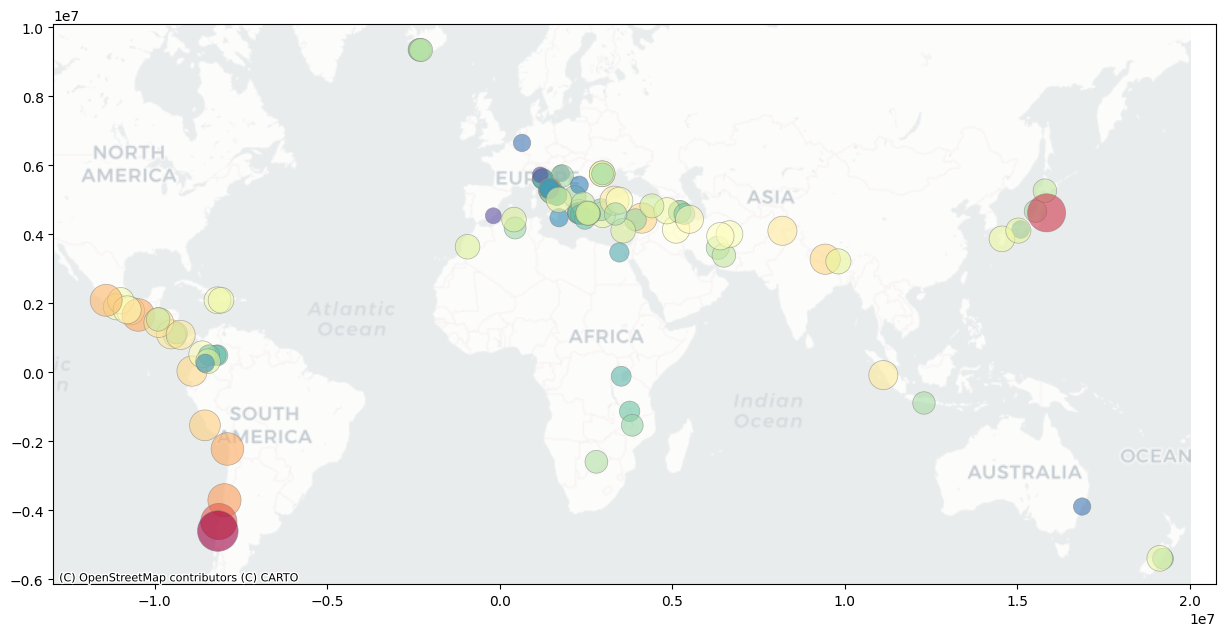

In [ ]:
# Create GeoDataFrame
df.rename(columns={ 'Latitude (decimal degrees)': 'Latitude',
                    'Longitude (decimal degrees)': 'Longitude'}, inplace=True)
gdf = gpd.GeoDataFrame(df,
                       geometry=gpd.points_from_xy(df.Longitude, 
                                                   df.Latitude),
                       crs='EPSG:4326')

# Reproject based on the coordinates of basemap
if gdf.crs != 'EPSG:3857':
    gdf = gdf.to_crs(epsg=3857)

# Plot events
fig, ax = plt.subplots(figsize=(15, 12)) # , alpha=0.5) # alpha not supported in OQ libraries
ax.set_aspect('equal')
gdf.plot(ax=ax,
         column='Mw',
         alpha=0.6,
         cmap="Spectral_r",
         marker='o', 
         markersize=df.Mw ** 3,
         edgecolor='grey', 
         linewidth=0.5,
         label='Event_Name',
        #  legend=True,
         )

# # Add labels to figure !!!! Needs more work because of overlaping labels
# lbl = 'Year' # options: 'Year', 'Event_Name '
# for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf[lbl]):
#     ax.annotate(label, 
#                 xy=(x, y), 
#                 xytext=(3, 3), 
#                 textcoords="offset points",
#                 color='black',
#                 fontsize='small')

# Add default basemap: CartoDB.Positron (uses Web Mercator --> epsg=3857)
# Additional basemaps available at:
# https://contextily.readthedocs.io/en/latest/providers_deepdive.html#What-is-this-%E2%80%9Cprovider%E2%80%9D-object-?
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron,
                crs=gdf.crs, alpha=0.5)


# Save figure
file_path = os.path.join('..', 'World', 'eq_events.png')
fig.savefig(file_path, facecolor="w", 
            dpi=100, bbox_inches='tight')

### Text of home README

In [ ]:
# README text

text = f'''
<div align='center'>
<p align="center">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/Global_Earthquake_Model_Logo.png/440px-Global_Earthquake_Model_Logo.png" alt="GEM Foundation" width="300"/>
</p>
<a href='./earthquake_scenarios/'>
    <img src='https://img.shields.io/badge/Earthquake_Scenarios-green?style=for-the-badge'>
</a>
<a href='./World/'>
    <img src='https://img.shields.io/badge/Global_coverage-gray?style=for-the-badge'>
</a>
<a href='./contribute_guidelines.md'>
    <img src='https://img.shields.io/badge/Contribute-orange?style=for-the-badge'>
</a>
<a href='LICENSE.txt'>
    <img src='https://img.shields.io/badge/LICENSE-blue?style=for-the-badge'>
</a>
</div>

# 🔎 Global Earthquake Impact Database (GEID)

The development of probabilistic seismic risk assessment (PSRA) models requires stress-testing 
the various components of the models, often through the assessment of damage and losses 
considering the characteristics of past events[^1]. In this context, the GEM Foundation and 
its partners have expanded the OpenQuake scenario damage and loss calculator to use directly 
USGS ShakeMaps[^2][^3][^4], or earthquake data from other providers (e.g., INGV, EFEHR) or the 
scientific literature. This functionality allows users to generate cross-correlated ground 
motion fields considering recordings from seismic stations [^5], to compute a number of 
risk metrics based on different rupture solutions and ground motion models, and to compare the 
results against past observations and damage reports. An overview of the functionalities implemented 
within the OpenQuake engine can be found at https://github.com/gem/oq-engine/issues/8317.

# ✨ Overview

The Global Earthquake Impact Database (GEID) aims to provide both earthquake and impact data 
for users to perform earthquake scenarios using GEM or their own models for validation 
and verification purposes. This database serves as a complement to the 
[USGS ShakeMap](https://earthquake.usgs.gov/data/shakemap/) Atlas and AtlasCat. 
The former resource has ShakeMaps for a comprehensive catalogue of nearly all 
near-damaging and damaging events worldwide for the past 120 years and can be used directly 
for impact assessment within the OpenQuake engine [^4]. The latter provides aggregate losses 
for each event separated by cause. The GEID builds upon these sources of data by collecting additional 
earthquake and impact information, often documented spatially and with greater detail.

> The v2023.0.0 release for the Global Earthquake Impact Database (GEID) is available! 🥳 🚀

<div align='left'>
    <img src="./World/eq_events.png" alt="GEID events" width="700"/>
</div>

This database is open and aims at being a community effort, that enables users to add new events 
(see [contributing guidelines](./contribute_guidelines.md)) or to provide additional data to 
existing entries. We aim to continue expanding the GEID by leveraging on data often collected within 
the scope of GEM projects, as well as data previously collected as part of the 
[GEM Earthquake Consequences Database](https://www.globalquakemodel.org/gempublications/Introduction-to-the-GEM-Earthquake-Consequences-Database-(GEMECD)).

## 🗺️ Database coverage

The database is compatible with GEM's Global Models, and the folders are organized according to regions and countries/territories, as specified in the map and table below.

<p align="center">
  <img src="./World/World_Regions.png" alt="World regions" width="600">
</p>

<details>
<summary> 🌍 Regions, countries and territories
</summary>

| REGION                    | COUNTRIES AND TERRITORIES |
|---------------------------|---------------------------|
| Africa                    | Algeria, Angola, Benin, Botswana, Burkina_Faso, Burundi, Cameroon, Cape_Verde, Central_African_Republic, Chad, Comoros, Congo, Democratic_Republic_of_the_Congo, Djibouti, Egypt, Equatorial_Guinea, Eritrea, Eswatini, Ethiopia, Gabon, Gambia, Ghana, Guinea, Guinea_Bissau, Ivory_Coast, Kenya, Lesotho, Liberia, Libya, Madagascar, Malawi, Mali, Mauritania, Mauritius, Morocco, Mozambique, Namibia, Niger, Nigeria, Rwanda, Sao_Tome_and_Principe, Senegal, Seychelles, Sierra_Leone, Somalia, South_Africa, South_Sudan, Sudan, Tanzania, Togo, Tunisia, Uganda, Zambia, Zimbabwe |
| Caribbean_Central_America | Anguilla, Antigua_and_Barbuda, Aruba, Bahamas, Barbados, Belize, British_Virgin_Islands, Cayman_Islands, Costa_Rica, Cuba, Dominica, Dominican_Republic, El_Salvador, Grenada, Guadeloupe, Guatemala, Haiti, Honduras, Jamaica, Martinique, Montserrat, Nicaragua, Panama, Puerto_Rico, Saint_Kitts_and_Nevis, Saint_Lucia, Saint_Vincent_and_the_Grenadines, Trinidad_and_Tobago, Turks_and_Caicos_Islands, US_Virgin_Islands |
| Central_Asia              | Kazakhstan, Kyrgyzstan, Tajikistan, Turkmenistan, Uzbekistan |
| East_Asia                 | China, Hong_Kong, Japan, Macao, North_Korea, South_Korea, Taiwan |
| Europe                    | Albania, Andorra, Austria, Belarus, Belgium, Bosnia_and_Herzegovina, Bulgaria, Croatia, Cyprus, Czechia, Denmark, Estonia, Finland, France, Germany, Gibraltar, Greece, Hungary, Iceland, Ireland, Isle_of_Man, Italy, Kosovo, Latvia, Liechtenstein, Lithuania, Luxembourg, Malta, Moldova, Monaco, Montenegro, Netherlands, North_Macedonia, Norway, Poland, Portugal, Romania, Serbia, Slovakia, Slovenia, Spain, Sweden, Switzerland, Turkey, Ukraine, United_Kingdom |
| Middle_East               | Afghanistan, Armenia, Azerbaijan, Bahrain, Georgia, Iran, Iraq, Israel, Jordan, Kuwait, Lebanon, Oman, Pakistan, Palestine, Qatar, Saudi_Arabia, Syria, United_Arab_Emirates, Yemen |
| North_America             | Canada, Mexico, United_States_of_America |
| North_Asia                | Mongolia, Russia |
| Oceania                   | American_Samoa, Australia, Cook_Islands, Fiji, Guam, Kiribati, Marshall_Islands, Micronesia, Nauru, New_Caledonia, New_Zealand, Niue, Northern_Mariana_Islands, Palau, Papua_New_Guinea, Samoa, Solomon_Islands, Tonga, Tuvalu, Vanuatu |
| South_America             | Argentina, Bolivia, Brazil, Chile, Colombia, Ecuador, French_Guiana, Guyana, Paraguay, Peru, Suriname, Uruguay, Venezuela |
| South_Asia                | Afghanistan, Bangladesh, Bhutan, India, Nepal, Pakistan, Sri_Lanka |
| Southeast_Asia            | Brunei, Cambodia, Indonesia, Laos, Malaysia, Myanmar, Philippines, Singapore, Thailand, Timor_Leste, Vietnam |

</details>

The following events are available, with a global summary of impact data available in the [World folder](./World).

<details>
<summary> List with available events
</summary>

{events_table}

</details>

# 🚀 Model versions

Each version of the archive that is released can be accessed by changing from the `main` branch to the `tag` of a given version.
The `main` branch could contain the work-in-progress of the next version of the model.

| Version   | Release Notes                                                            |
|-----------|--------------------------------------------------------------------------|
| [v2023.0.0](https://github.com/gem/geid/tree/v2023.0.0) | First release with 100 earthquake scenario events.|

# 🌟 Contributors

The authors are grateful for the input from dozens of collaborators. 

# License
[![CC BY-NC-SA 4.0][cc-by-nc-sa-shield]][cc-by-nc-sa]

This work is licensed under a
[Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License][cc-by-nc-sa].

[![CC BY-NC-SA 4.0][cc-by-nc-sa-image]][cc-by-nc-sa]

[cc-by-nc-sa]: http://creativecommons.org/licenses/by-nc-sa/4.0/
[cc-by-nc-sa-image]: https://licensebuttons.net/l/by-nc-sa/4.0/88x31.png
[cc-by-nc-sa-shield]: https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg

# 🤔 Frequently asked questions

### How to contribute?

You can follow the instructions indicated in the [contributing guidelines](./contribute_guidelines.md).

### Which version am I seeing? How to change the version?

By default, you will see the files in the repository in the `main` branch. Each version of the model that is released can be accessed is marked with a `tag`. By changing the tag version at the top of the repository, you can see the files for a given version.

Note that the `main` branch could contain the work-in-progress of the next version of the model.

### How do I download the data for a given version?

For each version, a related zip file is available in the [release section](https://github.com/gem/global_exposure_model/releases).

# References
[^1]: Villar-Vega, M., Silva, V. (2017). Assessment of earthquake damage considering the characteristics of past events in South America. Earthquake Engineering and Soil Dynamics, 99:86-96.
[^2]: Silva V, Horspool N (2019). Combining USGS ShakeMaps and the OpenQuake engine for damage and loss assessment. Earthquake Engineering and Structural Dynamics. 48(6):634-652.
[^3]: Worden, C. B., Thompson, E. M., Hearne, M. G., & Wald, D. J. (2020). ShakeMap Manual Online: technical manual, user’s guide, and software guide, U. S. Geological Survey. URL: http://usgs.github.io/shakemap/. DOI: https://doi.org/10.5066/F7D21VPQ.
[^4]: Wald, D. J., Worden, C. B., Thompson, E. M., & Hearne, M. G. (2022). ShakeMap operations, policies, and procedures. Earthquake Spectra, 38(1), 756–777. DOI: https://doi.org/10.1177/87552930211030298.
[^5]: Engler, D. T., Worden, C. B., Thompson, E. M., & Jaiswal, K. S. (2022). Partitioning Ground Motion Uncertainty When Conditioned on Station Data. Bulletin of the Seismological Society of America, 112(2), 1060–1079. DOI: https://doi.org/10.1785/0120210177.

'''

# Save README
f=open(os.path.join('..', 'README.md'), 'w')
f.write(text)
f.close()
